In [1]:
#Imports
import pathlib
import numpy as np
import pandas as pd

# pycytominer imports
from pycytominer.cyto_utils.cells import SingleCells
from pycytominer import aggregate, annotate, normalize, feature_select

# ignore mix type warnings from pandas
import warnings
#plotting
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
import math
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import joypy
import scipy
from scipy import stats
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [3]:
# Setting file paths
data_dir = pathlib.Path("/mnt/bigdisk1/Allie_S/Replicative_Age_Project/CP_Output/Mar26").resolve(strict=True)
plate = "Mar26_mitolyso_v2"
metadata_dir = (data_dir / "metadata").resolve(strict=True)

plate_map = (metadata_dir / 'map.csv').resolve(strict=True)

In [5]:
# input file paths for csv
image_path = pathlib.Path(data_dir / plate / "Image.csv").resolve(strict=True)
cell_path = pathlib.Path(data_dir / plate / "Cell.csv").resolve(strict=True)
nuc_path = pathlib.Path(data_dir / plate / "Nuclei.csv").resolve(strict=True)
mito_path = pathlib.Path(data_dir / plate / "MaskedMito.csv").resolve(strict=True)
#lyso_path = pathlib.Path(data_dir / plate / "Lysosomes_PerCell.csv").resolve(strict=True)

In [4]:
#Import the platemap
platemap_df = pd.read_csv(plate_map)
print(platemap_df.columns.tolist())

['Metadata_Well', 'Metadata_WellRow', 'Metadata_WellColumn', 'Metadata_Field', 'TimepointName', 'Replicate', 'Time', 'PassageNumber', 'Staining', 'Drug']


In [47]:
# loading plate map and display it


# displaying platemap
print(platemap_df.columns.tolist())

#Import the cellprofiler csv files using dask to save memory
image_df = pd.read_csv(image_path)
pre_nuclei_df = pd.read_csv(nuc_path)
pre_cell_df = pd.read_csv(cell_path)#, usecols=['ObjectNumber','ImageNumber','Metadata_Well', 'Metadata_Field', 
                                     #     'Metadata_WellColumn', 'Metadata_WellRow', 'AreaShape_Area',
                                      #   'AreaShape_Eccentricity','Children_Lysosomes_Count', 'Children_Mitochondria_Count',
                                       #   'Math_Lysosome_Cell_Ratio', 'Math_Mitochondria_Cell_Ratio'], index_col = False)
#pre_lyso_df = pd.read_csv(lyso_path)#, usecols=['ObjectNumber','ImageNumber','Metadata_Well', 'Metadata_Field',
                                     #     'Metadata_WellColumn', 'Metadata_WellRow', 'AreaShape_Area',
                                      #   'AreaShape_Eccentricity','Parent_Cell','Intensity_MedianIntensity_LAMP1',
                                       #  'Intensity_MeanIntensity_LAMP1','Texture_Contrast_LAMP1_3_01_256'],index_col = False)
pre_mito_df = pd.read_csv(mito_path)#, usecols=['ObjectNumber','ImageNumber','Metadata_Well', 'Metadata_Field',
                                     #     'Metadata_WellColumn', 'Metadata_WellRow', 'AreaShape_Area',
                                      #   'AreaShape_Eccentricity','Parent_Cell','Intensity_MedianIntensity_MitoTracker',
                                       #  'Intensity_MeanIntensity_MitoTracker','Texture_Contrast_MitoTracker_3_01_256'],index_col = False)

print(pre_nuclei_df.columns.tolist())

['Metadata_Well', 'Metadata_WellRow', 'Metadata_WellColumn', 'Metadata_Field', 'TimepointName', 'Replicate', 'Time', 'PassageNumber', 'Staining', 'Drug']
['ImageNumber', 'ObjectNumber', 'Metadata_ChannelNumber', 'Metadata_Field', 'Metadata_FileLocation', 'Metadata_Frame', 'Metadata_QCFlag_Nuclei', 'Metadata_Series', 'Metadata_Well', 'Metadata_WellColumn', 'Metadata_WellRow', 'AreaShape_Area', 'AreaShape_BoundingBoxArea', 'AreaShape_BoundingBoxMaximum_X', 'AreaShape_BoundingBoxMaximum_Y', 'AreaShape_BoundingBoxMinimum_X', 'AreaShape_BoundingBoxMinimum_Y', 'AreaShape_Center_X', 'AreaShape_Center_Y', 'AreaShape_Compactness', 'AreaShape_ConvexArea', 'AreaShape_Eccentricity', 'AreaShape_EquivalentDiameter', 'AreaShape_EulerNumber', 'AreaShape_Extent', 'AreaShape_FormFactor', 'AreaShape_MajorAxisLength', 'AreaShape_MaxFeretDiameter', 'AreaShape_MaximumRadius', 'AreaShape_MeanRadius', 'AreaShape_MedianRadius', 'AreaShape_MinFeretDiameter', 'AreaShape_MinorAxisLength', 'AreaShape_Orientation',

### Metadata columns
['ImageNumber', 'ObjectNumber', 'Metadata_ChannelNumber', 'Metadata_Field', 
 'Metadata_FileLocation', 'Metadata_Frame', 'Metadata_QCFlag_Nuclei', 'Metadata_Series', 'Metadata_Well', 'Metadata_WellColumn', 'Metadata_WellRow',
### Areashape features 
 'AreaShape_Area', 'AreaShape_BoundingBoxArea', 'AreaShape_BoundingBoxMaximum_X', 'AreaShape_BoundingBoxMaximum_Y',
 'AreaShape_BoundingBoxMinimum_X', 'AreaShape_BoundingBoxMinimum_Y', 'AreaShape_Center_X', 'AreaShape_Center_Y', 'AreaShape_Compactness', 'AreaShape_ConvexArea', 'AreaShape_Eccentricity', 
 'AreaShape_EquivalentDiameter', 'AreaShape_EulerNumber', 'AreaShape_Extent', 'AreaShape_FormFactor', 'AreaShape_MajorAxisLength', 'AreaShape_MaxFeretDiameter', 'AreaShape_MaximumRadius', 
 'AreaShape_MeanRadius', 'AreaShape_MedianRadius', 'AreaShape_MinFeretDiameter', 'AreaShape_MinorAxisLength', 'AreaShape_Orientation', 'AreaShape_Perimeter', 'AreaShape_Solidity', 
 'AreaShape_Zernike_0_0', 'AreaShape_Zernike_1_1', 'AreaShape_Zernike_2_0', 'AreaShape_Zernike_2_2', 'AreaShape_Zernike_3_1', 'AreaShape_Zernike_3_3', 'AreaShape_Zernike_4_0', 'AreaShape_Zernike_4_2', 'AreaShape_Zernike_4_4', 'AreaShape_Zernike_5_1', 'AreaShape_Zernike_5_3', 'AreaShape_Zernike_5_5', 'AreaShape_Zernike_6_0', 'AreaShape_Zernike_6_2', 'AreaShape_Zernike_6_4', 'AreaShape_Zernike_6_6', 'AreaShape_Zernike_7_1', 'AreaShape_Zernike_7_3', 'AreaShape_Zernike_7_5', 'AreaShape_Zernike_7_7', 'AreaShape_Zernike_8_0', 'AreaShape_Zernike_8_2', 'AreaShape_Zernike_8_4', 'AreaShape_Zernike_8_6', 'AreaShape_Zernike_8_8', 'AreaShape_Zernike_9_1', 'AreaShape_Zernike_9_3', 'AreaShape_Zernike_9_5', 'AreaShape_Zernike_9_7', 'AreaShape_Zernike_9_9', 
### Per-child features
 #### Granularity
 'Children_Cytoplasm_Count', 'Granularity_10_LAMP1', 'Granularity_10_MitoTracker', 'Granularity_11_LAMP1',
 'Granularity_11_MitoTracker', 'Granularity_12_LAMP1', 'Granularity_12_MitoTracker', 'Granularity_13_LAMP1', 
 'Granularity_13_MitoTracker', 'Granularity_14_LAMP1', 'Granularity_14_MitoTracker', 'Granularity_15_LAMP1', 
 'Granularity_15_MitoTracker', 'Granularity_16_LAMP1', 'Granularity_16_MitoTracker', 'Granularity_1_LAMP1', 
 'Granularity_1_MitoTracker', 'Granularity_2_LAMP1', 'Granularity_2_MitoTracker', 'Granularity_3_LAMP1', 'Granularity_3_MitoTracker', 
 'Granularity_4_LAMP1', 'Granularity_4_MitoTracker', 'Granularity_5_LAMP1', 'Granularity_5_MitoTracker', 'Granularity_6_LAMP1',
 'Granularity_6_MitoTracker', 'Granularity_7_LAMP1', 'Granularity_7_MitoTracker', 'Granularity_8_LAMP1', 'Granularity_8_MitoTracker', 'Granularity_9_LAMP1', 'Granularity_9_MitoTracker', 
 #### Loc
 'Location_Center_X', 'Location_Center_Y', 'Location_Center_Z', 
 ### Ratios
 'Math_Lysosome_Cell_Ratio', 'Math_Mitochondria_Cell_Ratio', 
 'Mean_MaskedLyso_Distance_Centroid_Cell', 'Mean_MaskedLyso_Location_Center_X', 
 'Mean_MaskedLyso_Location_Center_Y', 'Mean_MaskedLyso_Number_Object_Number',
 'Mean_MaskedMito_Distance_Centroid_Cell', 'Mean_MaskedMito_Location_Center_X', 
 'Mean_MaskedMito_Location_Center_Y', 'Mean_MaskedMito_Number_Object_Number', 
 'Number_Object_Number', 'Parent_Nuclei',
 #### Textures
 'Texture_AngularSecondMoment_LAMP1_3_00_256', 
 'Texture_AngularSecondMoment_LAMP1_3_01_256', 'Texture_AngularSecondMoment_LAMP1_3_02_256',
 'Texture_AngularSecondMoment_LAMP1_3_03_256', 'Texture_AngularSecondMoment_MitoTracker_3_00_256',
 'Texture_AngularSecondMoment_MitoTracker_3_01_256', 'Texture_AngularSecondMoment_MitoTracker_3_02_256', 
 'Texture_AngularSecondMoment_MitoTracker_3_03_256', 'Texture_Contrast_LAMP1_3_00_256', 
 'Texture_Contrast_LAMP1_3_01_256', 'Texture_Contrast_LAMP1_3_02_256', 
 'Texture_Contrast_LAMP1_3_03_256', 'Texture_Contrast_MitoTracker_3_00_256',
 'Texture_Contrast_MitoTracker_3_01_256', 'Texture_Contrast_MitoTracker_3_02_256',
 'Texture_Contrast_MitoTracker_3_03_256', 'Texture_Correlation_LAMP1_3_00_256',
 'Texture_Correlation_LAMP1_3_01_256', 'Texture_Correlation_LAMP1_3_02_256',
 'Texture_Correlation_LAMP1_3_03_256', 'Texture_Correlation_MitoTracker_3_00_256',
 'Texture_Correlation_MitoTracker_3_01_256', 'Texture_Correlation_MitoTracker_3_02_256', 
 'Texture_Correlation_MitoTracker_3_03_256', 'Texture_DifferenceEntropy_LAMP1_3_00_256',
 'Texture_DifferenceEntropy_LAMP1_3_01_256', 'Texture_DifferenceEntropy_LAMP1_3_02_256',
 'Texture_DifferenceEntropy_LAMP1_3_03_256', 'Texture_DifferenceEntropy_MitoTracker_3_00_256', 
 'Texture_DifferenceEntropy_MitoTracker_3_01_256', 'Texture_DifferenceEntropy_MitoTracker_3_02_256', 
 'Texture_DifferenceEntropy_MitoTracker_3_03_256', 'Texture_DifferenceVariance_LAMP1_3_00_256', 
 'Texture_DifferenceVariance_LAMP1_3_01_256', 'Texture_DifferenceVariance_LAMP1_3_02_256', 
 'Texture_DifferenceVariance_LAMP1_3_03_256', 'Texture_DifferenceVariance_MitoTracker_3_00_256', 
 'Texture_DifferenceVariance_MitoTracker_3_01_256', 'Texture_DifferenceVariance_MitoTracker_3_02_256'
 ,'Texture_DifferenceVariance_MitoTracker_3_03_256', 'Texture_Entropy_LAMP1_3_00_256',
 'Texture_Entropy_LAMP1_3_01_256', 'Texture_Entropy_LAMP1_3_02_256','Texture_Entropy_LAMP1_3_03_256', 
 'Texture_Entropy_MitoTracker_3_00_256', 'Texture_Entropy_MitoTracker_3_01_256', 
 'Texture_Entropy_MitoTracker_3_02_256', 'Texture_Entropy_MitoTracker_3_03_256', 
 'Texture_InfoMeas1_LAMP1_3_00_256', 'Texture_InfoMeas1_LAMP1_3_01_256', 
 'Texture_InfoMeas1_LAMP1_3_02_256', 'Texture_InfoMeas1_LAMP1_3_03_256', 
 'Texture_InfoMeas1_MitoTracker_3_00_256', 'Texture_InfoMeas1_MitoTracker_3_01_256',
 'Texture_InfoMeas1_MitoTracker_3_02_256', 'Texture_InfoMeas1_MitoTracker_3_03_256', 
 'Texture_InfoMeas2_LAMP1_3_00_256', 'Texture_InfoMeas2_LAMP1_3_01_256', 'Texture_InfoMeas2_LAMP1_3_02_256',
 'Texture_InfoMeas2_LAMP1_3_03_256', 'Texture_InfoMeas2_MitoTracker_3_00_256', 
 'Texture_InfoMeas2_MitoTracker_3_01_256', 'Texture_InfoMeas2_MitoTracker_3_02_256', 
 'Texture_InfoMeas2_MitoTracker_3_03_256', 'Texture_InverseDifferenceMoment_LAMP1_3_00_256', 
 'Texture_InverseDifferenceMoment_LAMP1_3_01_256', 'Texture_InverseDifferenceMoment_LAMP1_3_02_256',
 'Texture_InverseDifferenceMoment_LAMP1_3_03_256', 'Texture_InverseDifferenceMoment_MitoTracker_3_00_256', 
 'Texture_InverseDifferenceMoment_MitoTracker_3_01_256', 'Texture_InverseDifferenceMoment_MitoTracker_3_02_256',
 'Texture_InverseDifferenceMoment_MitoTracker_3_03_256', 'Texture_SumAverage_LAMP1_3_00_256', 
 'Texture_SumAverage_LAMP1_3_01_256', 'Texture_SumAverage_LAMP1_3_02_256', 
 'Texture_SumAverage_LAMP1_3_03_256', 'Texture_SumAverage_MitoTracker_3_00_256', 
 'Texture_SumAverage_MitoTracker_3_01_256', 'Texture_SumAverage_MitoTracker_3_02_256', 
 'Texture_SumAverage_MitoTracker_3_03_256', 'Texture_SumEntropy_LAMP1_3_00_256', 
 'Texture_SumEntropy_LAMP1_3_01_256', 'Texture_SumEntropy_LAMP1_3_02_256', 
 'Texture_SumEntropy_LAMP1_3_03_256', 'Texture_SumEntropy_MitoTracker_3_00_256', 
 'Texture_SumEntropy_MitoTracker_3_01_256', 'Texture_SumEntropy_MitoTracker_3_02_256', 
 'Texture_SumEntropy_MitoTracker_3_03_256', 'Texture_SumVariance_LAMP1_3_00_256',
 'Texture_SumVariance_LAMP1_3_01_256', 'Texture_SumVariance_LAMP1_3_02_256',
 'Texture_SumVariance_LAMP1_3_03_256', 'Texture_SumVariance_MitoTracker_3_00_256', 
 'Texture_SumVariance_MitoTracker_3_01_256', 'Texture_SumVariance_MitoTracker_3_02_256', 
 'Texture_SumVariance_MitoTracker_3_03_256', 'Texture_Variance_LAMP1_3_00_256',
 'Texture_Variance_LAMP1_3_01_256', 'Texture_Variance_LAMP1_3_02_256', 
 'Texture_Variance_LAMP1_3_03_256', 'Texture_Variance_MitoTracker_3_00_256', 
 'Texture_Variance_MitoTracker_3_01_256', 'Texture_Variance_MitoTracker_3_02_256', 
 'Texture_Variance_MitoTracker_3_03_256']


In [56]:
#Merge the dfs with the metadata
cell_df = pre_cell_df.merge(platemap_df, on=['Metadata_Well','Metadata_WellRow','Metadata_WellColumn','Metadata_Field'], how ='left')
#lyso_df = pre_lyso_df.merge(platemap_df, on=['Metadata_Well','Metadata_WellRow','Metadata_WellColumn','Metadata_Field'], how ='left')
#mito_df = pre_mito_df.merge(platemap_df, on=['Metadata_Well','Metadata_WellRow','Metadata_WellColumn','Metadata_Field'], how ='left')
nuclei_df = pre_nuclei_df.merge(platemap_df, on=['Metadata_Well','Metadata_WellRow','Metadata_WellColumn','Metadata_Field'], how ='left')

###cell_df.set_index('ObjectNumber')
#dfs are still of the dask df type 
#print(type(cell_df))


# Welcome to join hell
Joining two 6GB files will definitley crash...without a different approach (dask, SQL, or concat and remove dupes)

In [ ]:
#Trying with right join

#Rename the Cell object number column so pandas doesn't get confused
renamed_cell_df = cell_df.rename(columns={"ObjectNumber":"CellObjectNumber"})

intersect_cols = renamed_cell_df.columns.intersection(lyso_df.columns,sort=True).to_numpy
print(intersect_cols)

merged_lyso = renamed_cell_df.merge(lyso_df, how ='right', on=intersect_cols,
                            left_on='CellObjectNumber', right_on='Parent_CellOutline',
                            suffixes = ('_Cell','_Compartment'), indicator = True, broadcast = True)

display(merged_lyso.head(100).style)
#print(cell_df.head(100))

In [ ]:
#Trying with leftsemijoin

#Rename the Cell object number column so pandas doesn't get confused
renamed_cell_df = cell_df.rename(columns={"ObjectNumber":"CellObjectNumber"})


merged_lyso = lyso_df.merge(renamed_cell_df, how ='leftsemi', #on=['Metadata*],
                            right_on='CellObjectNumber', left_on='Parent_CellOutline',
                            suffixes = ('_Cell','_Compartment'), indicator = True)

display(merged_lyso.head(20))
print(merged_lyso.columns)

## Getting closer; but dask will drop the right columns... not ideal

In [ ]:
#Trying with a left whatever #crashes fml

#Rename the Cell object number column so pandas doesn't get confused
renamed_cell_df = cell_df.rename(columns={"ObjectNumber":"CellObjectNumber"})
#computed_lyso = lyso_df.compute()

merged_lyso = lyso_df.merge(renamed_cell_df, how = 'left',
                                  right_on='CellObjectNumber', left_on='Parent_CellOutline',
                                 suffixes = ('_Lyso','_Cell'), indicator = True)

merged_lyso.to_csv('path_to_merged.csv', index=False)

#print(merged_lyso.columns)


## Don't do this!
```python
##Try it in chunks

#Define the chunk size
chunk_size = 10000

# Initialize an empty list to store the merged chunks
merged_chunks = []

# Read the cell data once
pre_cell_df = pd.read_csv(cell_path, usecols=['ObjectNumber','ImageNumber','Metadata_Well', 'Metadata_Field', 
                                          'Metadata_WellColumn', 'Metadata_WellRow', 'AreaShape_Area',
                                         'AreaShape_Eccentricity','Children_Lysosomes_Count', 'Children_Mitochondria_Count',
                                          'Math_Lysosome_CellOutline_Ratio', 'Math_Mitochondria_CellOutline_Ratio'], index_col = False)

with open('merged.csv', 'w') as f:
    # Write the header
    header_written = False
    
    pre_lyso_df = pd.read_csv(lyso_path, usecols=['ObjectNumber','ImageNumber','Metadata_Well', 'Metadata_Field',
                                          'Metadata_WellColumn', 'Metadata_WellRow', 'AreaShape_Area',
                                         'AreaShape_Eccentricity','Parent_CellOutline','Intensity_MedianIntensity_LAMP1',
                                         'Intensity_MeanIntensity_LAMP1','Texture_Contrast_LAMP1_3_01_256'],index_col = False,chunksize = chunk_size)
    # Process the lysosome data in chunks
    for lysosome_chunk in pre_lyso_df:
        merged_chunk = pd.merge(lysosome_chunk, pre_cell_df, left_on='Parent_CellOutline', right_on='ObjectNumber', how='left')
        if not header_written:
            merged_chunk.to_csv(f, index=False)
            header_written = True
            merged_chunks.append(merged_chunk)
        else:
            merged_chunk.to_csv(f, index=False, header=False)

```
What's happening here is the **cartesian effect** - the join is seeing my rows as duplicates, and thus doing vector multiplication and making my life a living hell.
- Avoid left/right/outer joins when you aren't specifying "WHERE" to join on. Otherwise, the computer won't know what to do.


## This crashes
'''

danger_merged_lyso = merged_lyso.compute()
display(danger_merged_lyso.head(20))

'''

In [ ]:
display(merged_lyso.compute().head(20))

In [7]:
#valid_merged_lyso = merged_lyso[merged_lyso['CellObjectNumber'].notnull() & merged_lyso['Parent_CellOutline'].notnull()]
                        
print(f"Number of rows in merged DataFrame: {merged_lyso.shape[0].compute()}")
print(f"Number of unique lysosomes: {lyso_df.shape[0].compute()}")
print(f"Number of unique cells: {cell_df.shape[0].compute()}")
#group = merge_lyso.where()

#display(merged_lyso.compute().head(10))

Number of rows in merged DataFrame: 587282296
Number of unique lysosomes: 1270303
Number of unique cells: 7376


In [7]:
#Trying otut summary stats
sample_df = lyso_df.sample(frac=0.1).compute()  # Sample 1% of the data for visualization

display(sample_df.describe())

,ImageNumber,ObjectNumber,Metadata_Field,Metadata_WellColumn,Metadata_WellRow,AreaShape_Area,AreaShape_Eccentricity,Intensity_MeanIntensity_LAMP1,Intensity_MedianIntensity_LAMP1,Parent_CellOutline,Texture_Contrast_LAMP1_3_01_256,Replicate,Time,PassageNumber
count,127028.000000,127028.000000,127028.000000,127028.000000,127028.000000,127028.000000,127028.000000,127028.000000,127028.000000,127028.000000,127028.000000,127028.000000,127028.000000,127028.000000
mean,582.619289,955.064120,17.266453,4.118911,4.402982,140.886529,0.641414,0.109842,0.106502,4.510856,186.035958,3.118911,1.881089,11.030804
std,356.684464,839.815325,11.318295,1.347064,1.751927,125.296455,0.193960,0.057771,0.056714,5.026357,265.017958,1.347064,1.347064,3.631007
min,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000,0.000000,0.002317,0.002319,0.000000,0.000000,1.000000,0.000000,6.000000
25%,266.000000,341.000000,8.000000,3.000000,3.000000,48.000000,0.532778,0.070899,0.068559,1.000000,21.603488,2.000000,1.000000,9.000000
50%,562.000000,745.000000,15.000000,4.000000,4.000000,107.000000,0.673879,0.100315,0.096910,3.000000,103.834848,3.000000,2.000000,11.000000
75%,900.000000,1334.000000,26.000000,5.000000,6.000000,198.000000,0.787133,0.137081,0.132311,7.000000,246.845333,4.000000,3.000000,14.000000
max,1200.000000,7604.000000,40.000000,6.000000,7.000000,1287.000000,1.000000,0.932394,1.000000,36.000000,9516.976471,5.000000,4.000000,17.000000


In [ ]:
#Welcome to join hell - Aligned?


merged_lyso = cell_df.align(lyso_df, how ='right', on=['Metadata_Well','Metadata_WellRow','Metadata_WellColumn','Metadata_Field'],
                            left_on='ObjectNumber', right_on='Parent_CellOutline',
                            suffixes = ('_Cell','_Compartment'), indicator = True)

display(merged_lyso.head(100).style)
#print(cell_df.head(100))

In [ ]:
#Join hell but with vectors - if cross join works we might be so back
lyso_df_pd = lyso_df.compute()
cell_df_pd = cell_df.compute()

#merged_lyso = cell_df_pd.merge(lyso_df_pd, how ='cross') #its so over

In [ ]:
#Features to be used in plots and stats
cell_features = ['AreaShape_Area','AreaShape_Eccentricity','Children_Lysosomes_Count', 'Children_Mitochondria_Count',
                 'Math_Lysosome_CellOutline_Ratio', 'Math_Mitochondria_CellOutline_Ratio']
lyso_features = ['AreaShape_Area','AreaShape_Eccentricity','Intensity_MedianIntensity_LAMP1',
                 'Intensity_MeanIntensity_LAMP1','Texture_Contrast_LAMP1_3_01_256']
mito_features = ['AreaShape_Area','AreaShape_Eccentricity','Texture_Contrast_MitoTracker_3_01_256']
nuclei_features = ['AreaShape_Area','AreaShape_Eccentricity']

In [ ]:
#Make time int
for df in [mito_df, nuclei_df, cell_df, lyso_df]:

    df['Time'] = df['Time'].astype(int)

# Functions for Data Analysis
calulcate normalizations, remove extreme left outliers, etc

In [77]:
#Function to find the ratio between two columns in the two dataframes
def ratioCalc(df1, df2):
  int1 = df1['Intensity_MedianIntensity_CompensatedTfn']
  int2 = df2['Intensity_MedianIntensity_CompensatedTfn']

  temp_copy1 = outlier_removal(df1, int1)
  temp_copy2 = outlier_removal(df2, int2)

  intensity_ratio = temp_copy1[int1] / temp_copy1[int2]
  return df[intensity_ratio]

def standardize_group(df, columns):

    from sklearn.preprocessing import StandardScaler
   #Import the scaler and transform all time values to that of a standard distribution
    scaler = StandardScaler()
    scaled_df = scaler.fit_transform(df[columns])
    return scaled_df
    
def group_by_time(df, feature_list):
    
    #Group columns by time and apply groupby function to the DF
    df_groupby = df.groupby('Time').apply(lambda x: standardze group(x,feature_list))
 
    return df_groupby

def outlier_removal(df, column):
    # Create a copy of the column and the 'Time' column, along with parent nuclei
    column_copy = df[column].copy()
    time_column = df['Time'].copy()
    nuc_number = df['Parent_Nuclei'].copy()
    # Create a mini DataFrame with the column and 'Time' values
    mini_df = pd.DataFrame({column: column_copy, 'Time': time_column, 'Parent_Nuclei': nuc_number})
    mini_df = mini_df.dropna()

    #remove values for big nuclei each type of data
    nuc_mini = nuclei_df[['Number_Object_Number','AreaShape_Area','Time']].copy()
    # remove stuff within the range of t4
    nuc_t4_mean = np.mean(nuc_mini[nuc_mini['Time'] == 4])
    nuc_t4_std_dev = np.std(nuc_mini[nuc_mini['Time'] == 4])
    nuc_threshold = nuc_t4_mean + (3 * nuc_t4_std_dev)

    try:
        thresh_nuc = nuc_mini[nuc_mini['AreaShape_Area'] <= threshold].dropna()
        #thresh_nuc = thresh_nuc.reset_index(drop=True)
        #Now remove the dropped nuclei from dropped cells
        mini_df = mini_df[mini_df['Parent_Nuclei'].equals(thresh_nuc['ObjectNumber'])]
        mini_df = mini_df.reset_index(drop=True)
    except:
        print("Exception: Nuclei don't match")

    #Get rid of the 0 values
    mini_df = mini_df.loc[(mini_df[column] > 0)]
    mini_df = mini_df.reset_index(drop=True)
    
      # Calculate top and bottom percentiles for Time == 0
    p1 = np.percentile(mini_df[column], 5)
    p3 = np.percentile(mini_df[column], 95)

    # Filter out values greater than 3IQR from Q1 , NOT Q3
    filtered_mini_df = mini_df.loc[(mini_df[column] >= p1)]
    fitlered_mini_df = filtered_mini_df.dropna()
 
    return filtered_mini_df



# if df.equals(mito_df) or df.equals(lysosomes_df):
# if df[Parents] == nuclei_df[ObjectNumber]. - only have the above if
#if 'Area' in column:
# Calculate mean and standard deviation for Time == 4

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3588559871.py, line 23)

In [ ]:

def stats(df, cols, excel_name):
    
    stats_cols = cols
    with pd.ExcelWriter(excel_name) as writer:

      for column in cols:
        temp_copy = df.copy()  # Create a copy of the DataFrame for processing

        if 'Intensity' in column:
          temp_copy[column] = normamlization(temp_copy, column)
          temp_copy = outlier_removal(temp_copy, column)
        else:
          temp_copy[column] = mad_normalization(temp_copy, column)

          temp_copy = outlier_removal(temp_copy, column)

        # Perform pairwise Tukey's HSD test
        tukey = pairwise_tukeyhsd(endog=temp_copy[column], groups=temp_copy['Time'])

        # Extract relevant results
        results = np.array(tukey.summary().data)[:, [0, 1, 3, 6]]
        df_results = pd.DataFrame(results, columns=['Group 1', 'Group 2', 'p-value', 'Reject']).drop([0])
        df_results.reset_index(drop=True, inplace=True)
        df_results[['Group 1', 'Group 2']] = df_results[['Group 1', 'Group 2']].astype(int)
        df_results['p-value'] = df_results['p-value'].astype(float)
        # Truncate the column name if it exceeds 31 characters
        name = column[:31]

        # Save DataFrame to Excel sheet without the index column
        df_results.to_excel(writer, sheet_name=name, index=False)


# Call your stats below (anova)

In [ ]:
stats(mito_df, # dataframe name: mito_df, nuclei_df, image_df, outline_df, lysosomes_df
      mito_features, # list of columns specified in the cell right above, modify to make it work for a specific dataset
      'mar13_mito_stats.xlsx') # name of the excel file you are gonna save stats to

# Make the plots and validate dist

In [54]:
def make_layout(xtitle,ytitle):
  design = go.Layout(
        plot_bgcolor="#FFF",
        xaxis=dict(
            title=xtitle,
            linecolor="black",
            showgrid=False,
            titlefont=dict(size=20),
            tickfont=dict(size=16, color="black")
        ),
        yaxis=dict(
            title=ytitle,
            linecolor="black",
            showgrid=False,
            titlefont=dict(size=20),
            tickfont=dict(size=16, color="black")
        ),
        font=dict(size=14),
        legend=dict(
            title="",
            itemsizing='constant',
            font=dict(size=16, color="black"),
            tracegroupgap=10,
            traceorder='normal',
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
        boxgap=0.4,
        boxgroupgap=0.05,
        width=900,  # Specify width of the plot
        height=600
    )
  return design

def box_param(fig, color, design):
  fig.update_traces(boxmean=True)
  fig.update_traces(jitter=1.0)
  fig.update_traces(boxpoints=False)
  fig.update_layout(design)
  fig.update_traces({'opacity': 0.9})
  fig.update_traces(marker_color=color)
  return fig

In [50]:
def boxplot(df, variable, ytitle, xtitle, box_color, save=False, save_name=None):
    # #some styling stuff
  layout = make_layout(xtitle,ytitle)
  temp_copy = df.copy()
  if 'Intensity' in variable:
    temp_copy = outlier_removal(temp_copy, variable)
    temp_copy[variable] = normalization(temp_copy, variable)

  else:
    temp_copy = outlier_removal(temp_copy, variable)
    temp_copy[variable] = standard_scaling(temp_copy, variable)

  fig = px.box(temp_copy, x="Time", y=variable)
  fig = box_param(fig, box_color, layout)
  fig.update_traces(quartilemethod="linear")
  fig.show()
  
  if save==True:
      fig.write_image(save_name)

##  Call plotly
```python
boxplot(df, # dataframe name: mito_df, nuclei_df, image_df, outline_df, lysosomes_df
        'Variable', # the variable you wanna plot, column name
        'Y Title',# name of your y-axis (custom)
        'Time Point',#name of your x-axis (custom)
        'Red', # color of the boxes
        save=True, # if wanna save change to False to True, False is default
        save_name='_boxplot.png') #specify the name of the plot that you save

```

Exception: Nuclei don't match


/home/mattiazzilab/miniforge3/envs/cytomining/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3800: FutureWarning:

The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



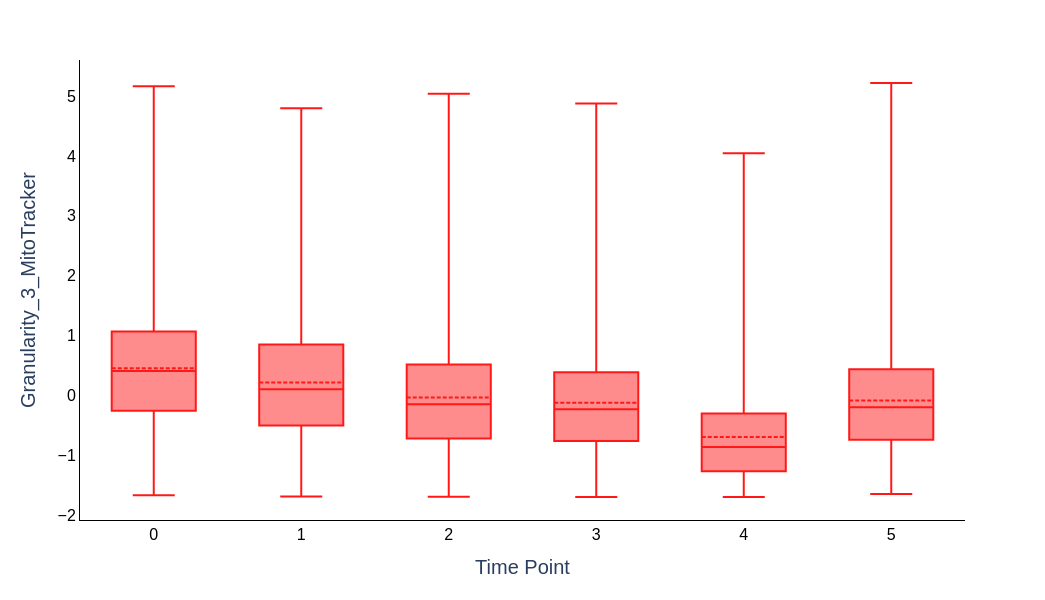

In [76]:
#testing
boxplot(cell_df,
            'Granularity_3_MitoTracker',
            'Granularity_3_MitoTracker',
            "Time Point",
            'Red',
            save = False,
            save_name = "_boxplot.png")

In [ ]:
#save all the files for that one feature

colors_i = 0
compartment = 'Cell'

for feature in lyso_features:
    title = compartment + '_' + feature
    boxplot(lyso_df,
            feature,
            feature,
            "Time Point",
            px.colors.qualitative.Pastel[colors_i],
            save = True,
            save_name = plate + "_" + compartment + "_" + feature + "_boxplot.png")
    colors_i = colors_i + 1
    
            
    

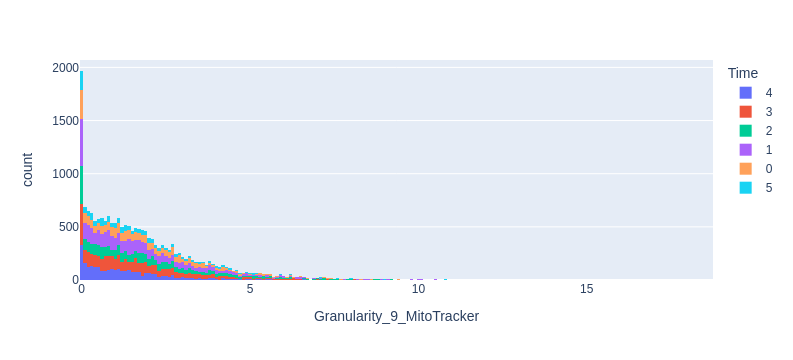

In [38]:
fig = px.histogram(cell_df, x='Granularity_3_MitoTracker', color = 'Time')
fig.show()

In [ ]:
fig = px.histogram(outlier_removal(lyso_df,'Intensity_MedianIntensity_LAMP1'), x='Intensity_MedianIntensity_LAMP1', color = 'Time')
fig.update_xaxes(range=[0,1])
fig.show()

# Pycytominer Testing: Use on single-cell profiles